<a href="https://colab.research.google.com/github/overthemoonlala/movie/blob/main/%EC%98%81%ED%99%94_%EA%B4%80%EA%B0%9D%EC%88%98_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (7,952 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122531 files and di

# 영화관객수 예측

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
from scipy.special import boxcox1p, inv_boxcox1p


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA 
- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수


box_off_num : 예측피쳐

In [4]:
train = pd.read_csv('/content/drive/MyDrive/moviedata/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/moviedata/movies_train.csv')
submission = pd.read_csv('/content/drive/MyDrive/moviedata/submission.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [7]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [8]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [9]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        243 non-null    object
 1   box_off_num  243 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [10]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [11]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(600, 12)
(243, 2)


In [12]:
#결측치 확인
train.isnull().sum() # dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [13]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
time,600.0,1.008633e+02,1.809753e+01,45.0,89.00,100.000,114.000,180.0
dir_prev_bfnum,270.0,1.050443e+06,1.791408e+06,1.0,20380.00,478423.625,1286568.625,17615314.0
dir_prev_num,600.0,8.766667e-01,1.183409e+00,0.0,0.00,0.000,2.000,5.0
num_staff,600.0,1.511183e+02,1.656547e+02,0.0,17.00,82.500,264.000,869.0
num_actor,600.0,3.706667e+00,2.446889e+00,0.0,2.00,3.000,4.000,25.0
box_off_num,600.0,7.081818e+05,1.828006e+06,1.0,1297.25,12591.000,479886.750,14262766.0


In [15]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
time,600.0,1.008633e+02,1.809753e+01,45.0,89.00,100.000,114.000,180.0
dir_prev_bfnum,270.0,1.050443e+06,1.791408e+06,1.0,20380.00,478423.625,1286568.625,17615314.0
dir_prev_num,600.0,8.766667e-01,1.183409e+00,0.0,0.00,0.000,2.000,5.0
num_staff,600.0,1.511183e+02,1.656547e+02,0.0,17.00,82.500,264.000,869.0
num_actor,600.0,3.706667e+00,2.446889e+00,0.0,2.00,3.000,4.000,25.0
box_off_num,600.0,7.081818e+05,1.828006e+06,1.0,1297.25,12591.000,479886.750,14262766.0


In [16]:
# 장르별 관객수
genre_count = train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')
genre_count

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


In [17]:
# 장르별 관객수 막대차트 그리기
genre_graph = train.groupby(['genre'], as_index = False)['box_off_num'].sum()
genre_graph

,genre,box_off_num
0,SF,23248494
1,공포,24814966
2,느와르,61119768
3,다큐멘터리,6247020
4,드라마,138277444
5,멜로/로맨스,33225507
6,뮤지컬,33135
7,미스터리,8968319
8,서스펜스,165222
9,애니메이션,3820460


<BarContainer object of 12 artists>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47476 (\N{HANGUL SYLLABLE REU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func

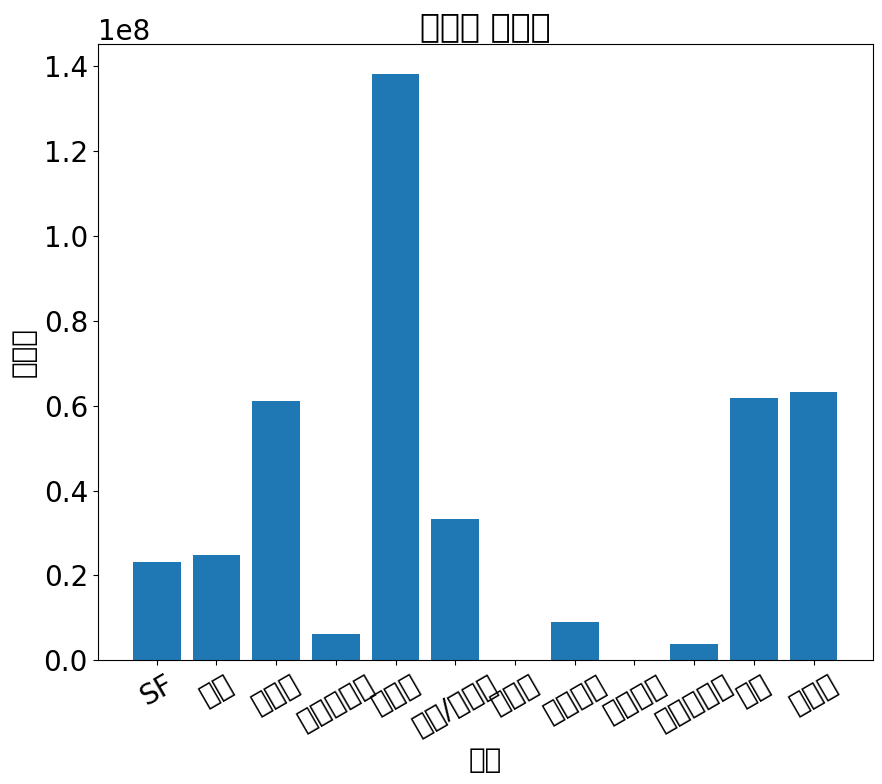

In [18]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10,8)
plt.title('장르별 관객수')
plt.xlabel('장르')
plt.ylabel('관객수')
plt.xticks(rotation= 30)
plt.bar(genre_graph['genre'], genre_graph['box_off_num'])

In [19]:
#변수간 상관계수 확인
corr_mat = train.corr()
corr_mat_ranking = corr_mat['box_off_num'].sort_values(ascending =False)
corr_mat_ranking

<ipython-input-19-ed198a113943>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = train.corr()


box_off_num       1.000000
num_staff         0.544265
time              0.441452
dir_prev_bfnum    0.283184
dir_prev_num      0.259674
num_actor         0.111179
Name: box_off_num, dtype: float64

In [20]:
corr_mat_ranking

box_off_num       1.000000
num_staff         0.544265
time              0.441452
dir_prev_bfnum    0.283184
dir_prev_num      0.259674
num_actor         0.111179
Name: box_off_num, dtype: float64

In [21]:
# 히트맵 그리기

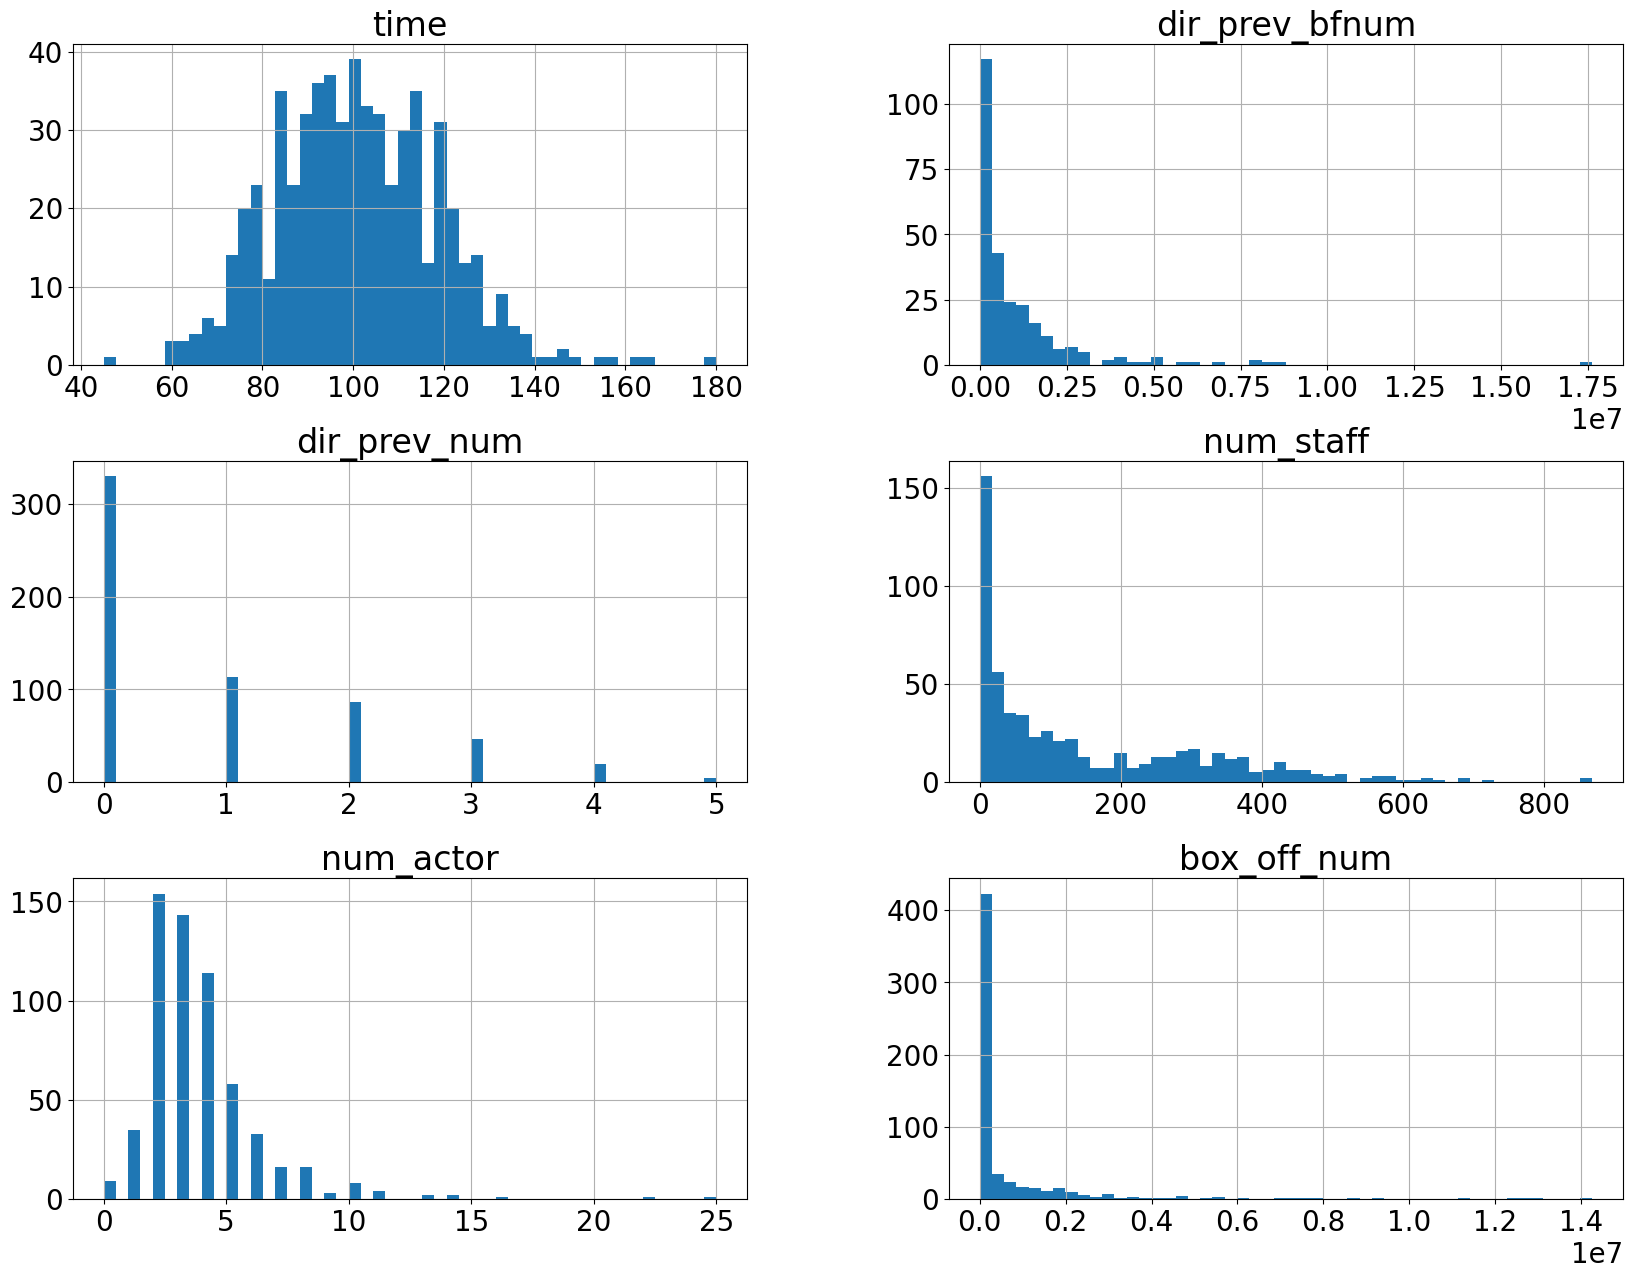

In [22]:
# 히스토그램으로 변수 분포 확인
import matplotlib.pyplot as plt
%matplotlib inline

train.hist(bins = 50, figsize = (20,15))
plt.show()